In [202]:
import pandas as pd
import numpy as np
import os
import sys
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [195]:
import sklearn
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [196]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Input, Embedding
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [197]:
TRAIN = 5000
SEG_SIZE = 100
TRAIN_SEG = round(TRAIN / SEG_SIZE)
LABELED_USERS = 10
EMBEDDING_DIM = 128

In [198]:
def load_user_data(dir_path='FraudedRawData'):
    df = pd.DataFrame()
    for file in os.listdir(dir_path):
        tmp = pd.read_csv(dir_path + '/' + file, sep=' ', header=None)
        df = pd.concat([df, tmp], axis=1)
    df = df.T.reset_index(drop=True)
    seg_df = pd.DataFrame()
    for i in range(150):
        seg_df = pd.concat([seg_df, df.iloc[:, i:i + 100].apply(lambda x: ",".join(x.astype(str)).split(','), axis=1)],
                           axis=1, names=[str(i)])
    seg_df = seg_df.T.reset_index(drop=True).T
    return df, seg_df

In [199]:
def get_metrics(y_true, y_pred):
    y_true = y_true.values.flatten().tolist()
    print(f'Acc: {accuracy_score(y_true, preds)}')
    print(f'Precision: {precision_score(y_true, preds)}')
    print(f'Recall: {recall_score(y_true, preds)}')
    print(f'F1 Score: {f1_score(y_true, preds)}')
    conf_mat = confusion_matrix(y_true, preds)
    tp, tn = conf_mat[1, 1], conf_mat[0, 0]
    classification_score = tn + 9*tp
    final_grade = min(100, 95 * 3*classification_score/4575) # + 0.3 * report_grade
    print(f'Final Grade: {final_grade}/70')
    return final_grade
    # return preds

In [190]:
def create_svm_model(X_train, y_train, X_test, y_test, report_grade=90):
    svm = OneClassSVM(nu=0.5, gamma='auto')
    svm.fit(X_train)
    y_pred = [1 if p == -1 else 0 for p in svm.predict(X_test)]
    return y_pred

In [ ]:
def prepare_data():
    

In [193]:
df, seg_df = load_user_data()
print(df.shape)
print(seg_df.shape)
y = pd.read_csv('challengeToFill.csv').drop(columns=['Unnamed: 0']).T.reset_index(drop=True).T
y_train = y.iloc[:LABELED_USERS, :TRAIN_SEG]
y_test = y.iloc[:LABELED_USERS, TRAIN_SEG:]
train_df = df.iloc[:LABELED_USERS, :TRAIN]
seg_train_df = seg_df.iloc[:, :TRAIN_SEG]
test_df = df.iloc[:LABELED_USERS, TRAIN:]
seg_test_df = seg_df.iloc[:LABELED_USERS, TRAIN_SEG:]
submission_df = seg_df.iloc[LABELED_USERS:, TRAIN_SEG:]
sentences = seg_train_df.to_numpy().flatten().tolist()
embedding_model = create_embeddings(sentences, vector_size=EMBEDDING_DIM, window=5)
print(embedding_model.wv)
# vec_df = seg_df.applymap(lambda x: embedding_model.wv[x].mean(axis=0))
# f = lambda x: embedding_model.wv[x].mean(axis=0)
# vfunc = np.vectorize(f)
vec_train_df = np.vstack(
    seg_train_df.applymap(embedding_model.wv.get_sentence_vector).to_numpy().reshape(-1, 1).tolist())
vec_test_df = np.vstack(
    seg_test_df.applymap(embedding_model.wv.get_sentence_vector).to_numpy().reshape(-1, 1).tolist())

print(vec_train_df.shape)
print(vec_test_df.shape)
print(train_df.shape)
print(test_df.shape)

(40, 15000)
(40, 150)
FastTextKeyedVectors<vector_size=128, 228 keys>
(2000, 128)
(1000, 128)
(10, 5000)
(10, 10000)


In [194]:
preds = create_svm_model(X_train=vec_train_df, y_train=y_train, X_test=vec_test_df, y_test=y_test)
get_metrics(y_test, preds)

Acc: 0.551
Precision: 0.08747044917257683
Recall: 0.37
F1 Score: 0.14149139579349906
Final Grade: 52.76393442622951/70


52.76393442622951

In [178]:
vec_train_df.shape

(2000, 128)

In [17]:
y_test = y.iloc[:LABELED_USERS, TRAIN_SEG:]
y_test = y_test.to_numpy().flatten()
y_test.shape, y_test.mean()

((1000,), 0.1)

In [16]:
vec_test_df.shape

(1000, 256)

In [30]:
tom_test.shape, np.expand_dims(y_test, axis=1).shape

((1000, 2), (1000, 1))

In [45]:
tmp = np.concatenate([tom_test, np.expand_dims(y_test, axis=1)], axis=-1)
print(tmp.shape)
# tmp[:, 0, y_test == 0]

(1000, 3)


In [51]:
tmp[tmp[:, 2] == 0].

(900, 3)

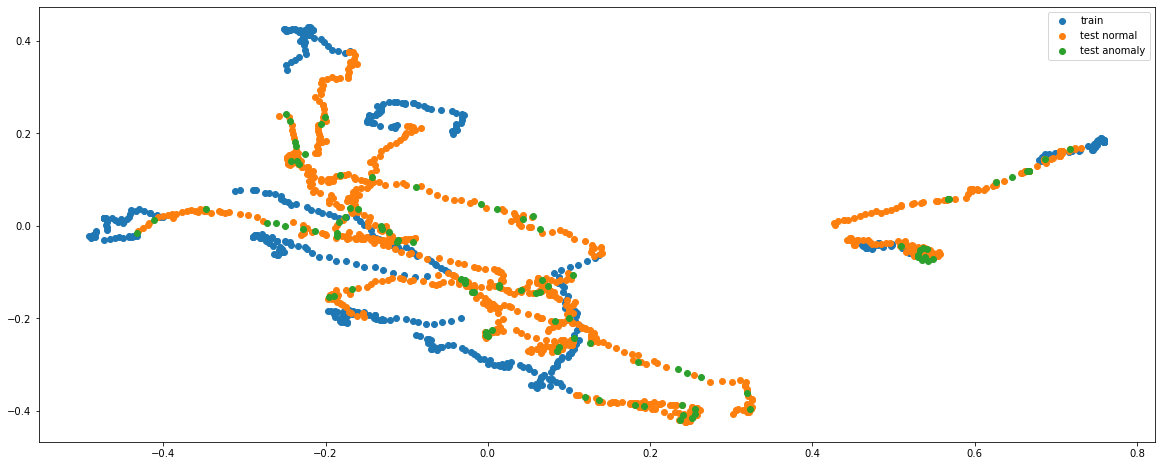

In [52]:
pca = PCA(n_components=2)
tom = pca.fit_transform(vec_train_df)
tom_test = pca.transform(vec_test_df)
tmp = np.concatenate([tom_test, np.expand_dims(y_test, axis=1)], axis=-1)
plt.figure(1, figsize=(20,8))
plt.scatter(tom[:,0], tom[:,1], label='train')
plt.scatter(tmp[tmp[:, 2] == 0][:,0], tmp[tmp[:, 2] == 0][:,1], label='test normal')
plt.scatter(tmp[tmp[:, 2] == 1][:,0], tmp[tmp[:, 2] == 1][:,1], label='test anomaly')
plt.legend()
plt.show()

In [26]:
tom[:,1].shape

(500,)

C:\Users\tom\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tom\.conda\envs\dl\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


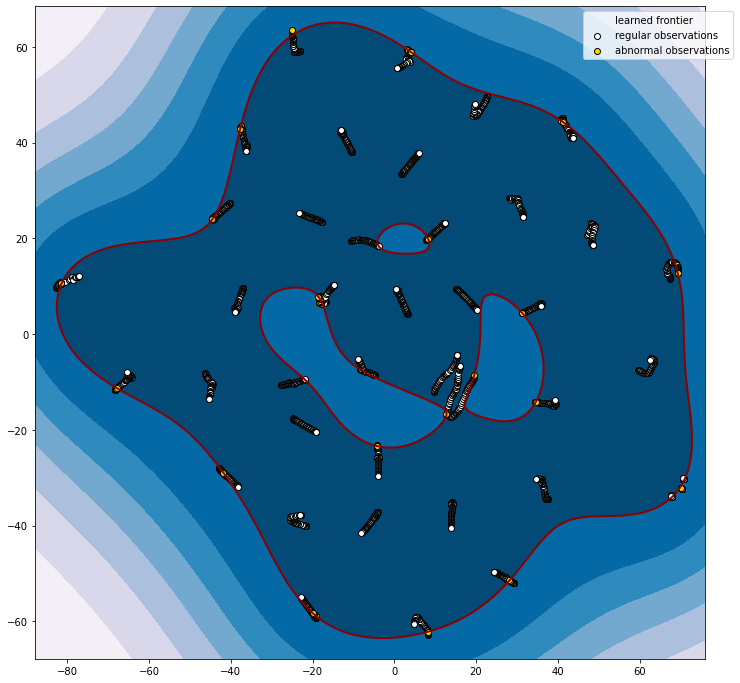

In [200]:
# from sklearn.svm import OneClassSVM
# from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# load the data
# df = pd.read_csv('data.csv')
# x = df.drop(labels='id', axis=1).values

# rescale the data
# x_scaled = MinMaxScaler().fit_transform(x)

# reduce the data to 2 dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=0)
x_reduced = tsne.fit_transform(vec_train_df)

# fit the model to the reduced data
# svm = OneClassSVM(kernel='rbf', nu=0.2, gamma=1e-04)
svm = OneClassSVM(nu=0.1, gamma=1e-3)
svm.fit(x_reduced)

# extract the model predictions
x_predicted = svm.predict(x_reduced)

# define the meshgrid
x_min, x_max = x_reduced[:, 0].min() - 5, x_reduced[:, 0].max() + 5
y_min, y_max = x_reduced[:, 1].min() - 5, x_reduced[:, 1].max() + 5

x_ = np.linspace(x_min, x_max, 500)
y_ = np.linspace(y_min, y_max, 500)

xx, yy = np.meshgrid(x_, y_)

# evaluate the decision function on the meshgrid
z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# plot the decision function and the reduced data
plt.figure(2, figsize=(12,12))
plt.contourf(xx, yy, z, cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='darkred')
b = plt.scatter(x_reduced[x_predicted == 1, 0], x_reduced[x_predicted == 1, 1], c='white', edgecolors='k')
c = plt.scatter(x_reduced[x_predicted == -1, 0], x_reduced[x_predicted == -1, 1], c='gold', edgecolors='k')
plt.legend([a.collections[0], b, c], ['learned frontier', 'regular observations', 'abnormal observations'], bbox_to_anchor=(1.05, 1))
plt.axis('tight')
plt.show()

In [155]:
vec_train_df.shape

(500, 128)

In [94]:
pd.Series(seg_train_df.to_numpy().flatten())

0      [cat, nawk, nawk, uname, pwd, echo, echo, ksh,...
1      [nawk, nawk, uname, pwd, echo, echo, ksh, unam...
2      [nawk, uname, pwd, echo, echo, ksh, uname, stt...
3      [uname, pwd, echo, echo, ksh, uname, stty, tse...
4      [pwd, echo, echo, ksh, uname, stty, tset, ksh,...
                             ...                        
495    [ls, id, ping, rlogin, rlogin, rlogin, id, rlo...
496    [id, ping, rlogin, rlogin, rlogin, id, rlogin,...
497    [ping, rlogin, rlogin, rlogin, id, rlogin, rlo...
498    [rlogin, rlogin, rlogin, id, rlogin, rlogin, k...
499    [rlogin, rlogin, id, rlogin, rlogin, ksh, xter...
Length: 500, dtype: object

In [96]:
seg_train_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,"[cat, nawk, nawk, uname, pwd, echo, echo, ksh,...","[nawk, nawk, uname, pwd, echo, echo, ksh, unam...","[nawk, uname, pwd, echo, echo, ksh, uname, stt...","[uname, pwd, echo, echo, ksh, uname, stty, tse...","[pwd, echo, echo, ksh, uname, stty, tset, ksh,...","[echo, echo, ksh, uname, stty, tset, ksh, move...","[echo, ksh, uname, stty, tset, ksh, movemail, ...","[ksh, uname, stty, tset, ksh, movemail, movema...","[uname, stty, tset, ksh, movemail, movemail, u...","[stty, tset, ksh, movemail, movemail, uname, u...",...,"[grep, find, ls, ls, ls, ls, ls, ls, ls, ls, u...","[find, ls, ls, ls, ls, ls, ls, ls, ls, uname, ...","[ls, ls, ls, ls, ls, ls, ls, ls, uname, uname,...","[ls, ls, ls, ls, ls, ls, ls, uname, uname, pwd...","[ls, ls, ls, ls, ls, ls, uname, uname, pwd, ec...","[ls, ls, ls, ls, ls, uname, uname, pwd, echo, ...","[ls, ls, ls, ls, uname, uname, pwd, echo, echo...","[ls, ls, ls, uname, uname, pwd, echo, echo, ks...","[ls, ls, uname, uname, pwd, echo, echo, ksh, u...","[ls, uname, uname, pwd, echo, echo, ksh, uname..."
1,"[cpp, sh, xrdb, cpp, sh, xrdb, mkpts, hostname...","[sh, xrdb, cpp, sh, xrdb, mkpts, hostname, stt...","[xrdb, cpp, sh, xrdb, mkpts, hostname, stty, e...","[cpp, sh, xrdb, mkpts, hostname, stty, env, tc...","[sh, xrdb, mkpts, hostname, stty, env, tcsh, t...","[xrdb, mkpts, hostname, stty, env, tcsh, tcsh,...","[mkpts, hostname, stty, env, tcsh, tcsh, tcsh,...","[hostname, stty, env, tcsh, tcsh, tcsh, sh, tc...","[stty, env, tcsh, tcsh, tcsh, sh, tcsh, kill, ...","[env, tcsh, tcsh, tcsh, sh, tcsh, kill, useren...",...,"[tcsh, tcsh, sh, kill, tcsh, userenv, wait4wm,...","[tcsh, sh, kill, tcsh, userenv, wait4wm, xhost...","[sh, kill, tcsh, userenv, wait4wm, xhost, xset...","[kill, tcsh, userenv, wait4wm, xhost, xsetroot...","[tcsh, userenv, wait4wm, xhost, xsetroot, reap...","[userenv, wait4wm, xhost, xsetroot, reaper, ca...","[wait4wm, xhost, xsetroot, reaper, cat, mail, ...","[xhost, xsetroot, reaper, cat, mail, tcsh, hos...","[xsetroot, reaper, cat, mail, tcsh, hostname, ...","[reaper, cat, mail, tcsh, hostname, stty, nets..."
2,"[cpp, sh, xrdb, cpp, sh, xrdb, mkpts, hostname...","[sh, xrdb, cpp, sh, xrdb, mkpts, hostname, env...","[xrdb, cpp, sh, xrdb, mkpts, hostname, env, cs...","[cpp, sh, xrdb, mkpts, hostname, env, csh, csh...","[sh, xrdb, mkpts, hostname, env, csh, csh, csh...","[xrdb, mkpts, hostname, env, csh, csh, csh, sh...","[mkpts, hostname, env, csh, csh, csh, sh, csh,...","[hostname, env, csh, csh, csh, sh, csh, kill, ...","[env, csh, csh, csh, sh, csh, kill, userenv, w...","[csh, csh, csh, sh, csh, kill, userenv, wait4w...",...,"[tset, launchef, sh, launchef, launchef, launc...","[launchef, sh, launchef, launchef, launchef, s...","[sh, launchef, launchef, launchef, sh, csh, xt...","[launchef, launchef, launchef, sh, csh, xterm,...","[launchef, launchef, sh, csh, xterm, launchef,...","[launchef, sh, csh, xterm, launchef, launchef,...","[sh, csh, xterm, launchef, launchef, sh, netst...","[csh, xterm, launchef, launchef, sh, netstat, ...","[xterm, launchef, launchef, sh, netstat, netsc...","[launchef, launchef, sh, netstat, netscape, ne..."
3,"[touch, touch, cat, ls, sed, ln, rm, sed, ln, ...","[touch, cat, ls, sed, ln, rm, sed, ln, rm, chm...","[cat, ls, sed, ln, rm, sed, ln, rm, chmod, sed...","[ls, sed, ln, rm, sed, ln, rm, chmod, sed, ln,...","[sed, ln, rm, sed, ln, rm, chmod, sed, ln, rm,...","[ln, rm, sed, ln, rm, chmod, sed, ln, rm, sed,...","[rm, sed, ln, rm, chmod, sed, ln, rm, sed, ln,...","[sed, ln, rm, chmod, sed, ln, rm, sed, ln, rm,...","[ln, rm, chmod, sed, ln, rm, sed, ln, rm, rm, ...","[rm, chmod, sed, ln, rm, sed, ln, rm, rm, sed,...",...,"[rm, chmod, sed, ln, rm, rm, chmod, rm, setup,...","[chmod, sed, ln, rm, rm, chmod, rm, setup, ksh...","[sed, ln, rm, rm, chmod, rm, setup, ksh, ksh, ...","[ln, rm, rm, chmod, rm, setup, ksh, ksh, cat, ...","[rm, rm, chmod, rm, setup, ksh, ksh, cat, tty,...","[rm, chmod, rm, setu

In [99]:
s = pd.Series(seg_train_df.to_numpy().flatten())
# s
X_train = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
X_train

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,cat,nawk,nawk,uname,pwd,echo,echo,ksh,uname,stty,...,sh,sh,xgvis,ln,sh,sh,sh,xgvis,sh,sh
1,nawk,nawk,uname,pwd,echo,echo,ksh,uname,stty,tset,...,sh,xgvis,ln,sh,sh,sh,xgvis,sh,sh,xgvis
2,nawk,uname,pwd,echo,echo,ksh,uname,stty,tset,ksh,...,xgvis,ln,sh,sh,sh,xgvis,sh,sh,xgvis,ls
3,uname,pwd,echo,echo,ksh,uname,stty,tset,ksh,movemail,...,ln,sh,sh,sh,xgvis,sh,sh,xgvis,ls,ls
4,pwd,echo,echo,ksh,uname,stty,tset,ksh,movemail,movemail,...,sh,sh,sh,xgvis,sh,sh,xgvis,ls,ls,sh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ls,id,ping,rlogin,rlogin,rlogin,id,rlogin,rlogin,ksh,...,sed,sed,rsh,nawk,cut,sort,sed,ipeek,ksh,rshd
496,id,ping,rlogin,rlogin,rlogin,id,rlogin,rlogin,ksh,xterm,...,sed,rsh,nawk,cut,sort,sed,ipeek,ksh,rshd,sh
497,ping,rlogin,rlogin,rlogin,id,rlogin,rlogin,ksh,xterm,rlogin,...,rsh,nawk,cut,sort,sed,ipeek,ksh,rshd,sh,cat
498,rlogin,rlogin,rlogin,id,rlogin,rlogin,ksh,xterm,rlogin,rlogin,...,nawk,cut,sort,sed,ipeek,ksh,rshd,sh,cat,stty


In [140]:
X_train.shape

(500, 100)

In [138]:
X_train.applymap(embedding_model.wv.get_vector).to_numpy().shape

(500, 100)

In [105]:
s = pd.Series(seg_test_df.to_numpy().flatten())
# s
X_test = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
X_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,uname,uname,pwd,echo,echo,ksh,uname,uname,pwd,echo,...,pwd,echo,echo,ksh,uname,uname,pwd,echo,echo,ksh
1,uname,pwd,echo,echo,ksh,uname,uname,pwd,echo,echo,...,echo,echo,ksh,uname,uname,pwd,echo,echo,ksh,mkdir
2,pwd,echo,echo,ksh,uname,uname,pwd,echo,echo,ksh,...,echo,ksh,uname,uname,pwd,echo,echo,ksh,mkdir,sendmail
3,echo,echo,ksh,uname,uname,pwd,echo,echo,ksh,mkdir,...,ksh,uname,uname,pwd,echo,echo,ksh,mkdir,sendmail,sendmail
4,echo,ksh,uname,uname,pwd,echo,echo,ksh,mkdir,uname,...,uname,uname,pwd,echo,echo,ksh,mkdir,sendmail,sendmail,ls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,sh,cat,stty,uname,ksh,cut,date,mesg,ksh,who,...,uname,uname,ds_ar,Archie,ksh,backtalk,ksh,ksh,ksh,grep
996,cat,stty,uname,ksh,cut,date,mesg,ksh,who,wc,...,uname,ds_ar,Archie,ksh,backtalk,ksh,ksh,ksh,grep,ksh
997,stty,uname,ksh,cut,date,mesg,ksh,who,wc,cut,...,ds_ar,Archie,ksh,backtalk,ksh,ksh,ksh,grep,ksh,cfe
998,uname,ksh,cut,date,mesg,ksh,who,wc,cut,ls,...,Archie,ksh,backtalk,ksh,ksh,ksh,grep,ksh,cfe,ugen


In [114]:
y_test = pd.Series(y_test.to_numpy().flatten(), name='label')

In [117]:
test = pd.merge(X_test, y_test, left_index=True, right_index=True)
test

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,uname,uname,pwd,echo,echo,ksh,uname,uname,pwd,echo,...,echo,echo,ksh,uname,uname,pwd,echo,echo,ksh,0.0
1,uname,pwd,echo,echo,ksh,uname,uname,pwd,echo,echo,...,echo,ksh,uname,uname,pwd,echo,echo,ksh,mkdir,0.0
2,pwd,echo,echo,ksh,uname,uname,pwd,echo,echo,ksh,...,ksh,uname,uname,pwd,echo,echo,ksh,mkdir,sendmail,0.0
3,echo,echo,ksh,uname,uname,pwd,echo,echo,ksh,mkdir,...,uname,uname,pwd,echo,echo,ksh,mkdir,sendmail,sendmail,0.0
4,echo,ksh,uname,uname,pwd,echo,echo,ksh,mkdir,uname,...,uname,pwd,echo,echo,ksh,mkdir,sendmail,sendmail,ls,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,sh,cat,stty,uname,ksh,cut,date,mesg,ksh,who,...,uname,ds_ar,Archie,ksh,backtalk,ksh,ksh,ksh,grep,0.0
996,cat,stty,uname,ksh,cut,date,mesg,ksh,who,wc,...,ds_ar,Archie,ksh,backtalk,ksh,ksh,ksh,grep,ksh,0.0
997,stty,uname,ksh,cut,date,mesg,ksh,who,wc,cut,...,Archie,ksh,backtalk,ksh,ksh,ksh,grep,ksh,cfe,0.0
998,uname,ksh,cut,date,mesg,ksh,who,wc,cut,ls,...,ksh,backtalk,ksh,ksh,ksh,grep,ksh,cfe,ugen,0.0


In [156]:
# np.vstack(
#     seg_train_df.applymap(embedding_model.wv.get_sentence_vector).to_numpy().reshape(-1, 1).tolist()).shape

In [161]:
vec_train_df.shape

(500, 128)

In [180]:
def build_model():
    inp = Input(shape=(EMBEDDING_DIM))
    # x = Embedding(SEG_SIZE, EMBEDDING_DIM, )(inp)
    # x = LSTM(units=64, return_sequences=True)(x)
    x = Dense(64)(inp)
    # x = Dropout(0.5)(x)
    x = Dense(32)(x)
    # x = Dropout(0.5)(x)
    x = Dense(16)(x)
    # x = Dropout(0.5)(x)
    x = Dense(32)(x)
    # x = Dropout(0.5)(x)
    x = Dense(64)(x)
    out = Dense(EMBEDDING_DIM, activation='relu')(x)
    model = Model(inputs=inp, outputs=out)
    return model

In [181]:
cp = ModelCheckpoint('model.h5', save_best_only=True, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=20, mode="min", verbose=1)
rlop = ReduceLROnPlateau(patience=3, verbose=1)
callbacks = [cp, es, rlop]

In [182]:
model = build_model()
model.compile(loss='mae', optimizer='adam', metrics='mae')
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_42 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_43 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_44 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_45 (Dense)             (None, 128)               832

In [183]:
model.fit(vec_train_df, vec_train_df, batch_size=8, epochs=50, validation_split=0.1, callbacks=callbacks)

Epoch 1/50
225/225 [==============================] - 1s 2ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0263 - val_mae: 0.0263

Epoch 00001: val_loss improved from inf to 0.02630, saving model to model.h5
Epoch 2/50
225/225 [==============================] - 0s 2ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0247 - val_mae: 0.0247

Epoch 00002: val_loss improved from 0.02630 to 0.02465, saving model to model.h5
Epoch 3/50
225/225 [==============================] - 0s 2ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0236 - val_mae: 0.0236

Epoch 00003: val_loss improved from 0.02465 to 0.02358, saving model to model.h5
Epoch 4/50
225/225 [==============================] - 0s 2ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0228 - val_mae: 0.0228

Epoch 00004: val_loss improved from 0.02358 to 0.02276, saving model to model.h5
Epoch 5/50
225/225 [==============================] - 0s 2ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0224 - val_mae: 0.0224

Epoch 00005: va